In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
print(os.listdir("data"))
np.random.seed(1337)
plt.rcParams["figure.figsize"] = (20,10)
sns.set() # plot styles

def quantile_loss(y_actual, y_predict):
    """
    Cost function to minimise
    - y_actual: the actual number of core hours consumed by the simulation (array-like)
    - y_predict: the model's prediction (array-like of same length as above)
    - returns positive number, the lower the better
    """
    quantile = 0.9
    errors = np.maximum((y_actual - y_predict) * quantile, (y_predict - y_actual) * (1.0 - quantile))
    return np.mean(errors)

['emod3d_test_x.csv', 'emod3d_train_x.csv', 'emod3d_train_y.csv']


In [2]:
df = pd.read_csv("data/emod3d_train_x.csv")
y = pd.read_csv("data/emod3d_train_y.csv").core_hours
test_x = pd.read_csv("data/emod3d_test_x.csv")
print(sum(y == 0))
df = df[y > 0]
y = y[y > 0]
display(df.describe())
display(y.describe())

39


,nt,nx,ny,nz,n_sub,n_cores
count,11795.000000,11795.00000,11795.000000,11795.000000,1.179500e+04,11795.000000
mean,6437.316914,737.01933,945.518440,155.330903,1.196169e+05,177.254769
std,2936.300451,386.95983,535.203539,61.300102,2.529458e+05,46.258255
min,1301.000000,136.00000,135.000000,82.000000,1.000000e+00,160.000000
25%,4183.000000,440.00000,549.000000,115.000000,4.212000e+04,160.000000
50%,5942.000000,669.00000,822.000000,122.000000,7.750400e+04,160.000000
75%,8263.000000,930.00000,1249.000000,230.000000,1.234500e+05,160.000000
max,17611.000000,2040.00000,3487.000000,390.000000,3.225600e+06,720.000000


count    11795.000000
mean        65.098713
std        120.467776
min          0.311111
25%          6.577778
50%         18.088889
75%         66.266667
max       1240.711111
Name: core_hours, dtype: float64

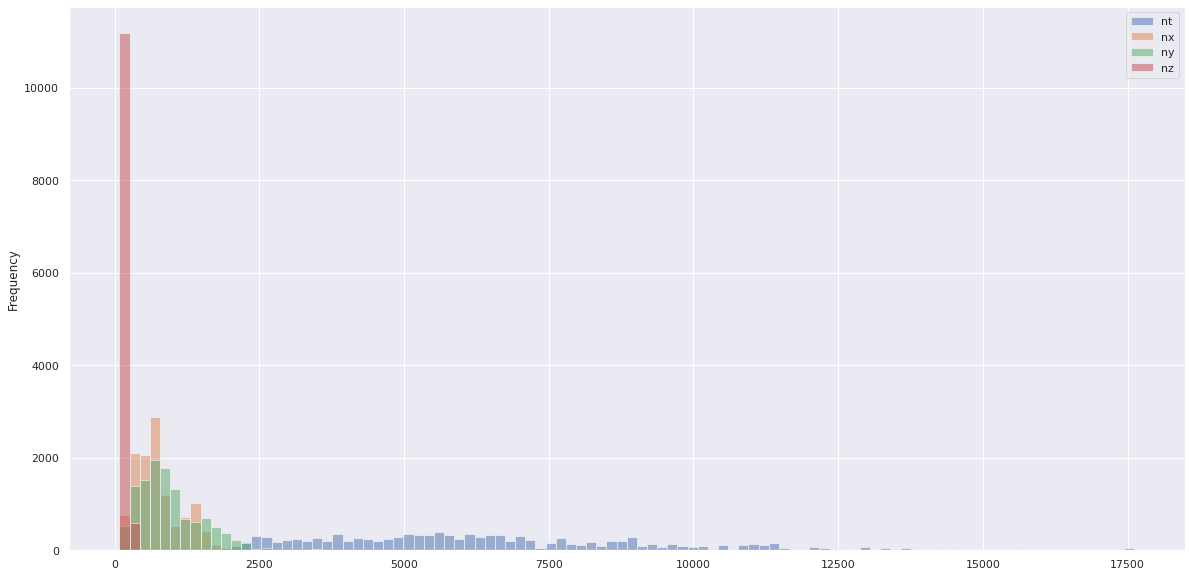

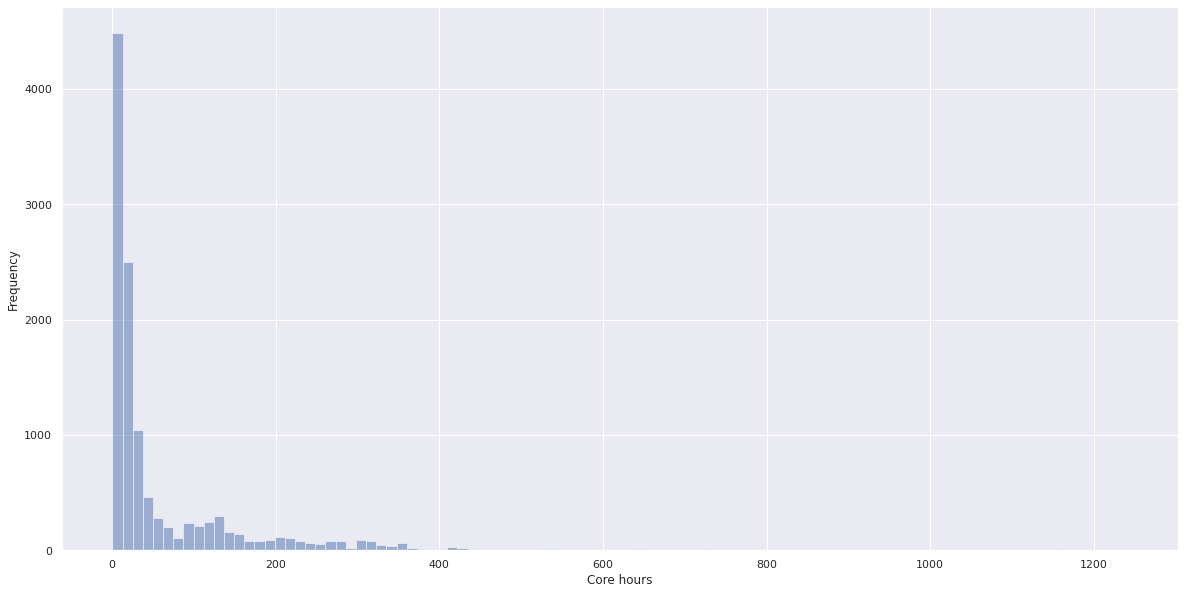

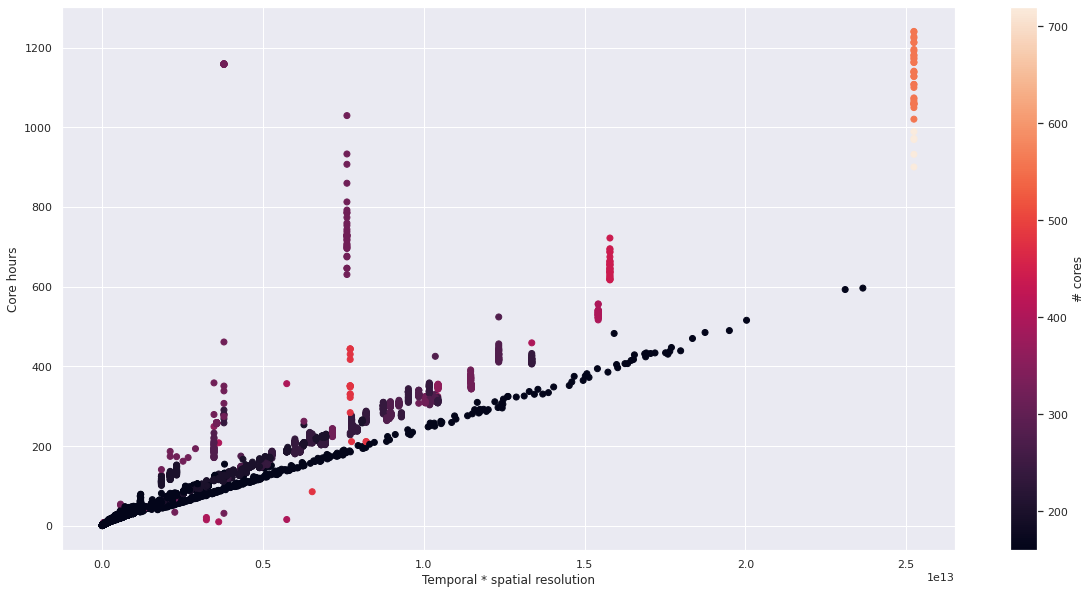

In [3]:
df[["nt", "nx", "ny", "nz"]].plot.hist(alpha=0.5, bins=100)
plt.show()
y.plot.hist(alpha=0.5, bins=100)
plt.xlabel('Core hours')
plt.show()
plt.scatter(df.nt * df.nx * df.ny * df.nz, y, c=df.n_cores)
plt.xlabel("Temporal * spatial resolution")
plt.ylabel("Core hours")
cbar = plt.colorbar()
cbar.set_label("# cores")

Text(0.5, 1.0, 'Correlation heatmap')

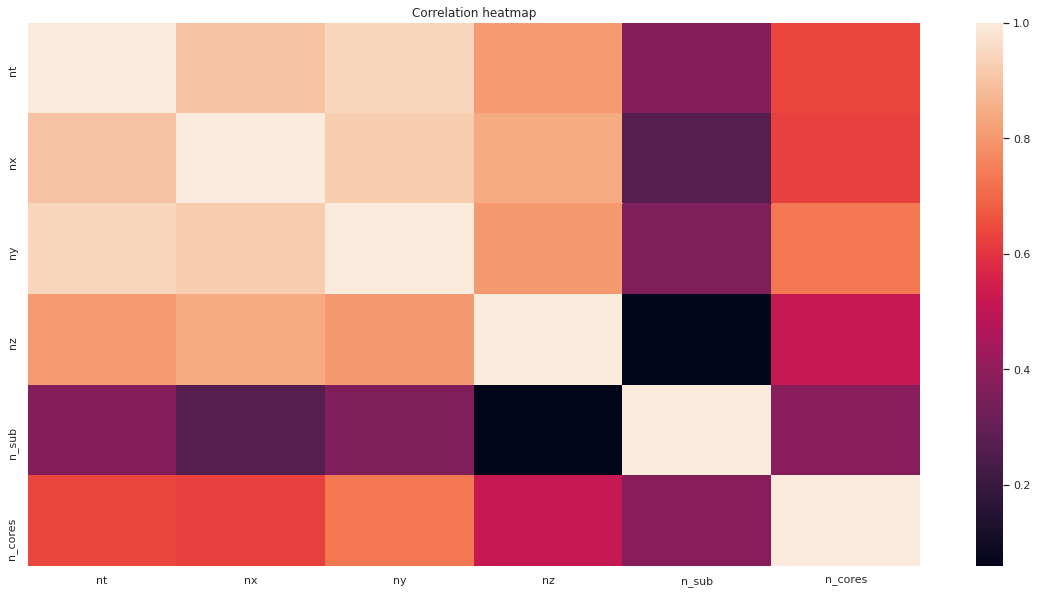

In [4]:
sns.heatmap(df.corr())
plt.title("Correlation heatmap")

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(df, y)
model = XGBRegressor()
model.fit(xtrain, ytrain)
quantile_loss(ytest, model.predict(xtest))

1.1054686395245505

Text(0, 0.5, 'Predicted value')

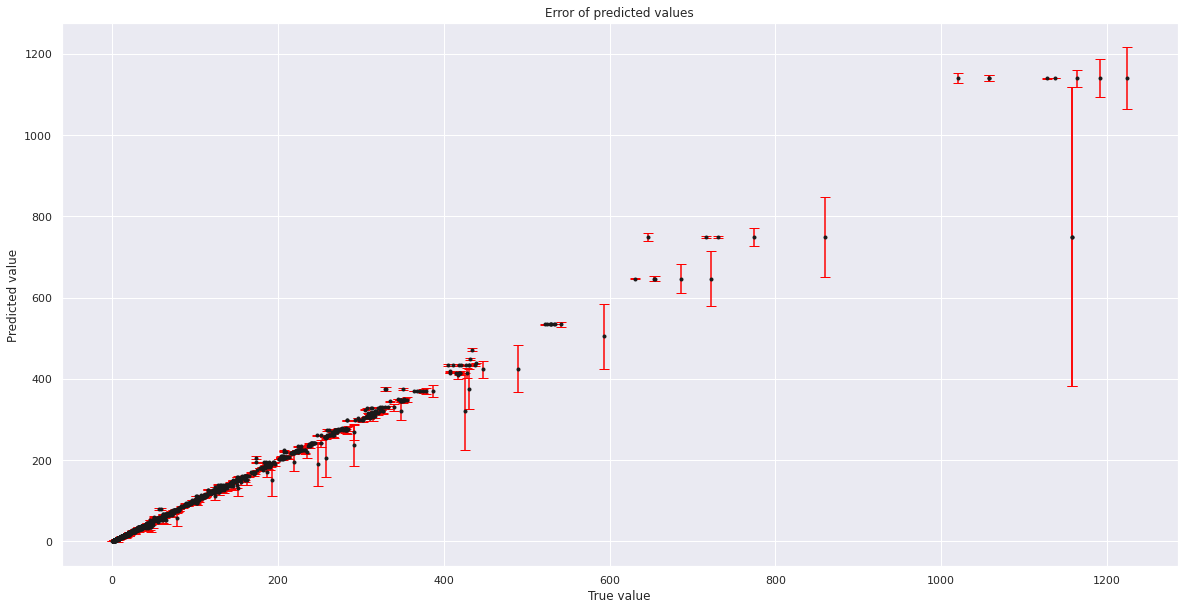

In [6]:
quantile = 0.9
pred = model.predict(xtest)
errors = np.maximum((ytest - pred) * quantile, (pred - ytest) * (1.0 - quantile))
plt.errorbar(ytest, pred, yerr=errors, fmt='.k', ecolor = 'red', markersize=6, capsize=5) # errors seem to increase with higher core_hours
plt.title("Error of predicted values")
plt.xlabel("True value")
plt.ylabel("Predicted value")

In [7]:
mask = errors > 100
tricky_rows = xtest[mask].copy()
tricky_rows["true value"] = ytest[mask]
tricky_rows["prediction"] = pred[mask]
tricky_rows["error"] = errors[mask]
tricky_rows

,nt,nx,ny,nz,n_sub,n_cores,true value,prediction,error
1316,11408.0,1208.0,1831.0,150.0,2035075,320.0,1157.866667,750.155029,366.940474
10826,11408.0,1208.0,1831.0,150.0,2035075,320.0,1158.044444,750.155029,367.100474


In [8]:
model.fit(df, y) # refit to all data
np.savetxt("emod3d_test_y.csv", model.predict(test_x), fmt='%s')
!head "emod3d_test_y.csv"

15.124461
325.2228
87.7428
124.4759
431.85638
21.606487
22.356478
4.8781424
0.6889113
33.2902
